In [1]:
from Data import AnnaDataset, InvertAnna, IntcodeAnna
from Models import BRNN
from Utils.HelperFunctions import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
%matplotlib inline  
# use gpu when possible
mydevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(mydevice)

cuda:0


In [2]:
# parameters
BATCH_SIZE = 512
N_STEPS = 10
N_HIDDEN = 512
N_PART = 2
N_LAYERS = 2
N_EPOCHS = 101
learning_rates = np.asarray([1e-4,5e-5,1e-5,5e-6,1e-6])
clip = 5
N_REPS = len(learning_rates)

dataset = AnnaDataset(N_STEPS)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

N_INPUTS = len(dataset.categories)
N_OUTPUTS = N_INPUTS

In [3]:
train_loss = np.zeros((N_EPOCHS,N_REPS))
train_acc = np.zeros((N_EPOCHS,N_REPS))

model = [None]*N_REPS
for rep in tnrange(N_REPS):
    model[rep] = BRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,N_PART,mydevice).to(mydevice)
    optimizer = torch.optim.RMSprop(model[rep].parameters(), lr=learning_rates[rep], momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model[rep].train()
    for epoch in tnrange(N_EPOCHS):
        running_train_loss = 0
        running_train_acc = 0
        for i, (x,y_tar) in enumerate(dataloader):
            x, y_tar = x.to(mydevice), y_tar.to(mydevice)
            y_pred, hidden = model[rep](x)
            loss = criterion(y_pred[-1,:,:],y_tar)
            loss.backward()
            nn.utils.clip_grad_norm(model[rep].parameters(), clip)
            optimizer.step()
            running_train_loss+=loss.item()
            running_train_acc+=get_accuracy(y_pred[-1,:,:], y_tar)
        train_loss[epoch,rep] = running_train_loss/(i+1)
        train_acc[epoch,rep] = running_train_acc/(i+1)

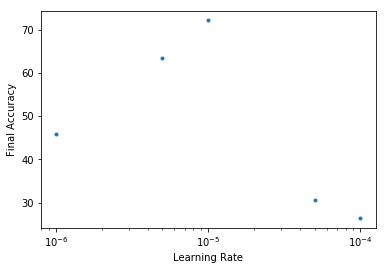

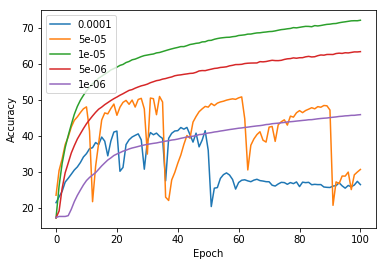

In [4]:
plt.plot(learning_rates,train_acc[-1,:],'.')
plt.xscale('log')
plt.ylabel('Final Accuracy')
plt.xlabel('Learning Rate')
plt.show()
plt.plot(train_acc)
plt.legend(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

ad not bee
at bo  de 


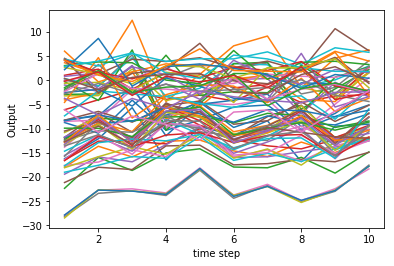

In [35]:
model[2].eval()
x, y_tar = next(iter(dataloader))
y_pred, hidden = model[2](x.to(mydevice))
trial_samp = np.random.randint(x.shape[0])
print(''.join(InvertAnna(torch.max(x[trial_samp,1:,:],1)[1]))+InvertAnna(y_tar)[trial_samp])
print(''.join(InvertAnna(torch.max(y_pred[:,trial_samp,:].squeeze(),1)[1])))
plt.plot(np.arange(1,11),y_pred.permute(1,2,0).data.cpu().numpy()[trial_samp,:,:].T,'-')
plt.ylabel('Output')
plt.xlabel('time step')
plt.show()